<a href="https://colab.research.google.com/github/mibeaum/ML/blob/master/TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Time series classification**



Load Python modules

In [1]:
import numpy as np  # Arrays, matrices and functions on them. Required by Pandas, below
import pandas as pd # A data analysis library
from sklearn.model_selection import train_test_split # scikit-learn, machine learning tools
import matplotlib.pyplot as plt # A plotting library
import seaborn as sns # Built on matplotlib, facilitates aesthetically pleasing plots
import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cluster
from sklearn import metrics

# General settings
sns.set_style('whitegrid') # Plots will have a white grid
# Variables that will help us work with the classes
class_names = ['workstation', 'server']
class_colors = ['darkorange', 'steelblue']

classifier_3NN = KNeighborsClassifier(n_neighbors=3, metric='euclidean')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Functions

In [13]:
def load_data(filename):
    ''' Load the data from a file in a GitHub repo '''
    url_root = 'https://raw.githubusercontent.com/mibeaum/ML/master'
    url = url_root+'/'+filename
    mydateparser = lambda x: ( 
       pd.to_datetime(x, format="%d/%m/%Y%H:%M:%S").strftime("%H")
    )    
    df = pd.read_csv(url, sep=',', header=0, usecols = ["server", "dateTime", "internalPacketIdentifier"], parse_dates=['dateTime'], date_parser=mydateparser) # Use Pandas to load the data into a Pandas DataFrame
    df["dateTime"] = df["dateTime"].astype(float)
    df.sort_values(by=['dateTime'])
    print('Loaded from', url)
    data = df.values # Convert from a Pandas DataFrame to a numpy array
    print('')
    return df

def plot_data_samples(df, labels):
    ''' Plot the time series data relating to the input list of sample numbers '''
    plt.scatter(df['dateTime'], df['server'])

    ylabels = [x for x in df['server']]
    plt.yticks(df['server'], ylabels)

    print('')
    #plt.set ylim([00.00, 23.59])
    plt.title('workstation (class 0): server (class 1)')
    plt.ylabel('Server')
    plt.xlabel('Time (Hours)')    

Load the data

In [14]:
filename = 'data.csv'
df = load_data(filename) 
data_log = df.values # Convert from a Pandas DataFrame to a numpy array
print('These are the first 7 rows of data_log:\n', data_log[0:7], '\n')

Loaded from https://raw.githubusercontent.com/mibeaum/ML/master/data.csv

These are the first 7 rows of data_log:
 [[0 8.0 '0000026335FA1560']
 [0 9.0 '0000026335FA1560']
 [1 19.0 '0000026335C83DB0']
 [1 20.0 '0000026335C83DB0']
 [0 10.0 '0000026338FC9920']
 [0 11.0 '0000026338FC9920']
 [0 11.0 '00000263351894F0']] 



Process the data

In [15]:
labels = data_log[:,0].astype(int)
data = data_log[:,1:]
print('The shape of the labels vector is', labels.shape)
print('The shape of the data matrix is', data.shape)
print('The labels is a vector. These are the first 7 elements of labels vector:\n', labels[0:7], '\n')
print('The data is a matrix. These are the first 7 rows of data matrix:\n', data[0:7], '\n')



The shape of the labels vector is (42,)
The shape of the data matrix is (42, 2)
The labels is a vector. These are the first 7 elements of labels vector:
 [0 0 1 1 0 0 0] 

The data is a matrix. These are the first 7 rows of data matrix:
 [[8.0 '0000026335FA1560']
 [9.0 '0000026335FA1560']
 [19.0 '0000026335C83DB0']
 [20.0 '0000026335C83DB0']
 [10.0 '0000026338FC9920']
 [11.0 '0000026338FC9920']
 [11.0 '00000263351894F0']] 



Plot the data

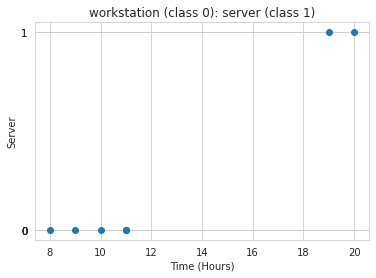

In [16]:
plot_data_samples(df[0:7], labels) 

Split the data set

In [17]:
test_size = 21

# Use the train_test_split from the scikit-learn (sklearn) module
data_train, data_test, labels_train, labels_test = train_test_split(
    data, labels, test_size=test_size, random_state=21, stratify=labels)

print('The shape of data_train is', data_train.shape)
print('The shape of data_test is', data_test.shape)
print('Train data:')
print('Number of samples of class 0', (labels_train == 0).sum())
print('Number of samples of class 1', (labels_train == 1).sum())
print('Test data:')
print('Number of samples of class 0', (labels_test == 0).sum())
print('Number of samples of class 1', (labels_test == 1).sum())


The shape of data_train is (21, 2)
The shape of data_test is (21, 2)
Train data:
Number of samples of class 0 13
Number of samples of class 1 8
Test data:
Number of samples of class 0 12
Number of samples of class 1 9


Train using the knearest neighbours classifier



In [18]:
classifier_3NN.fit(data_train[:,0].reshape(-1,1), labels_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Test using the knearest neighbours classifier

In [22]:
data_pred = classifier_3NN.predict(data_test[:,0].reshape(-1,1)) # Expects a 2 dimensional array not 1 (1,0) becomes ((1,),(0,))  

# create output dataframe 
output_pred = data_test.copy();
output_pred_df = pd.DataFrame({'server':labels_test, 'server_pred':data_pred})
output_pred_df["hour_pred"],output_pred_df["identifier_pred"] = output_pred[:,0], output_pred[:,1]



# output the accuracy scores
print(metrics.classification_report(data_pred, labels_test))

output_pred_df


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         9

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



,server,server_pred,hour_pred,identifier_pred
0,0,0,13,0000026338FC9920
1,0,0,14,00000263351894F0
2,1,1,20,0000026335C83DB0
3,1,1,22,0000026335C83DB0
4,0,0,15,0000026338FC9920
5,1,1,20,000002633810C960
6,0,0,11,00000263351894F0
7,1,1,23,0000026335C83DB0
8,0,0,10,0000026338FC9920
9,0,0,14,0000026335FA1560


Train using the k-means clustering classifier

In [147]:
assigned_clust = classifier_clust.fit(data_test[:,0].reshape(-1,1))
data_test[:,0]

array([13.0, 14.0, 20.0, 22.0, 15.0, 20.0, 11.0, 23.0, 10.0, 14.0, 11.0,
       3.0, 14.0, 16.0, 15.0, 18.0, 20.0, 19.0, 14.0, 10.0, 1.0],
      dtype=object)

Test using the k-means clustering classifier





In [146]:
# output the accuracy scores
print(metrics.classification_report(assigned_clust.labels_, labels_test))

              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.22      0.33      0.27         6

    accuracy                           0.48        21
   macro avg       0.44      0.43      0.43        21
weighted avg       0.54      0.48      0.50        21

